In [2]:
#Acessar Google Drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmp46m9aya_/pubring.gpg' created
gpg: /tmp/tmp46m9aya_/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [1]:
#Montar Drive
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [3]:
#bibliotecas e funções

#importa o tensorflow
import tensorflow as tf

#Usaremos o pandas para transformações basicas
import pandas as pd

#Numpy apenas para deixar o processo mais rapidas
import numpy as np

#sklearn para dividir o conjunto de treino e teste
from sklearn.cross_validation import train_test_split

#As metricas básica acuracia e confusion_matrix
from sklearn.metrics import confusion_matrix,accuracy_score

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis
from pandas import DataFrame
from pandas import read_csv
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import concatenate
from numpy import diff

#Usamos pandas para abrir o dataset
data = pd.read_csv('drive/Colab Notebooks/Anemo_dataset.csv')



/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [4]:
#mostra a matriz 'data' que recebe os valores do arquivo Anemo_dataset.csv na tela
data

,dia,mes,ano,hora,velocidade,direcao,temperatura,umidade,pressao
0,30,11,2015,14,13.942200,78.03996,27.51613,72.93064,1020.423
1,30,11,2015,15,12.928990,71.42997,27.23810,75.21212,1020.394
2,30,11,2015,16,12.092220,63.81983,27.10526,75.74138,1020.508
3,30,11,2015,17,11.380000,52.28789,26.30556,75.30263,1020.611
4,30,11,2015,18,10.109440,51.99191,25.46429,76.59259,1020.867
5,30,11,2015,19,9.247778,49.27006,24.76471,83.34444,1021.287
6,30,11,2015,20,8.508889,45.14458,24.31081,88.04464,1021.628
7,30,11,2015,21,8.012222,39.96379,24.30435,91.32967,1021.892
8,30,11,2015,22,7.898889,37.53199,24.50000,92.41538,1021.856
9,30,11,2015,23,6.396667,35.93918,24.41935,93.62963,1021.835


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 9 columns):
dia            744 non-null int64
mes            744 non-null int64
ano            744 non-null int64
hora           744 non-null int64
velocidade     744 non-null float64
direcao        744 non-null float64
temperatura    744 non-null float64
umidade        744 non-null float64
pressao        744 non-null float64
dtypes: float64(5), int64(4)
memory usage: 52.4 KB


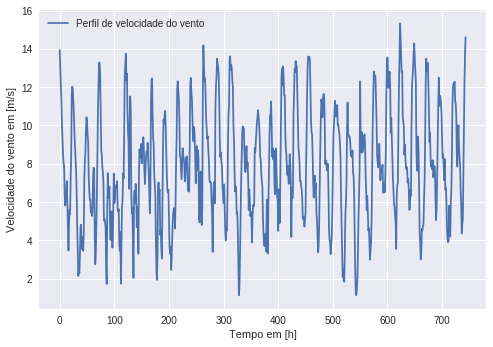

In [6]:
#mostrar o grafico na tela

#escolhe a coluna que quer plotar
plt.plot(data['velocidade'])

#escolhe os nomes dos eixos
plt.ylabel('Velocidade do vento em [m/s]')
plt.xlabel('Tempo em [h]')

#coloca o nome e posição da legenda
plt.legend(['Perfil de velocidade do vento'], loc='upper left')

#plota na tela
plt.show()

In [0]:
train_set = data.head(500)

In [0]:
test_set = data.tail(194)

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()

In [0]:
train_scaled = scaler.fit_transform(train_set)

In [0]:
test_scaled = scaler.fit_transform(test_set)

In [195]:
#não entendi estas definições.... ????????

def next_batch(training_data,batch_size,step):
  
  rand_start = np.random.randint(0,len(training_data)-steps)
  
  y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
  
  return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1)

In [194]:
#the constants

num_inputs = 9

num_time_steps = 1 # aqui é o intervalo de tempo de previsão em horas, por exemplo 1 hora a frente?????

num_neurons = 100

num_outputs = 1 #velocidade predita

learning_rate = 0.001

num_train_interations = 6000

batch_size = 1 # qual valor entra aqui??



In [196]:
#criando placeholders

X = tf.placeholder(tf.float64, [None, num_time_steps, num_inputs])

y = tf.placeholder(tf.float64, [None, num_time_steps, num_outputs])

In [197]:
#criando a RNN

cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons,activation=tf.nn.relu),output_size=num_outputs)

In [198]:
outputs , states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float64)

ValueError: ignored

In [182]:
#loss function and optimizer

loss = tf.reduce_mean(tf.square(outputs-y))

In [183]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

ValueError: ignored

In [184]:
#inicializa as variaveis globais

init = tf.global_variables_initializer()

In [185]:
#cria uma instaância 

svaer = tf.train.Saver()

In [186]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [187]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
  
  sess.run(init)
  
  for interation in range(num_train_interations):
    
    X_batch , y_batch = next_batch(train_scaled, batch_size, num_time_steps)
    
    sess.run(train, feed_dict={X:X_batch,y:y_batch})
    
    if iteration %100 == 0:
      
      mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
      print (iteration, "\tMSE", mse)
      
      #save model for later
      saver.save(sess, "./resultado")

NameError: ignored

In [188]:
test_set

,dia,mes,ano,hora,velocidade,direcao,temperatura,umidade,pressao
550,23,12,2015,12,12.291670,75.62424,21.51678,87.86111,1014.846
551,23,12,2015,13,9.195556,71.78465,23.07527,73.33889,1014.793
552,23,12,2015,14,8.583333,98.68189,22.54545,78.53333,1014.085
553,23,12,2015,15,9.651667,111.65340,21.45977,83.72222,1013.542
554,23,12,2015,16,8.583889,100.36720,22.13380,84.69128,1013.563
555,23,12,2015,17,8.683889,89.90298,22.82581,85.35897,1012.884
556,23,12,2015,18,8.928333,86.57528,22.77228,85.94771,1012.747
557,23,12,2015,19,9.335000,79.33692,23.25000,83.64972,1012.658
558,23,12,2015,20,9.537778,81.26876,23.37500,85.32090,1013.107
559,23,12,2015,21,9.018889,70.70263,23.63636,85.84106,1012.803


In [189]:
with tf.Session() as sess:
  
  saver.restore(sess, "./resultado")
  
  train_seed = list(train_scaled[-550:])
  
  for iteration in range(194):
    
    X_batch = np.array(train_seed[-num_time_steps: ]).reshape(1,num_time_steps,1)
    
    y_pred = sess.run(outputs, feed_dict={X:X_batch})
    
    train_seed.append(y_pred[0,-1,0])

NameError: ignored

In [190]:
train_seed

NameError: ignored

In [191]:
results = scaler.inverse_tranform(np.array(train_seed[194:]).reshape(194,1))

AttributeError: ignored

In [192]:
test_set['Generated'] = results

NameError: ignored

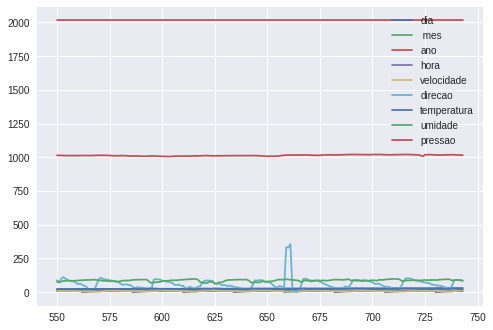

In [193]:
#objetivo aqui é plotar gráfico de comparação dos resultados medidos com os previstos

test_set.plot()

In [0]:
#links interessantes para leitura

#https://github.com/fengjiqiang/LSTM-Wind-Speed-Forecasting/blob/master/lstm.py

#https://github.com/viniroger/lstm/blob/master/lstm_ex.py